In [2]:
from tools import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.stats import multivariate_normal
from scipy.linalg import fractional_matrix_power
from scipy.stats import wishart
import sys
import time
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def reflect(x,xL,xU):
    n=0; side=0; e=0
    if (x<xL):
        e = xL-x; side=0 
    elif(x>xU):
        e = x-xU; side=1
    n = int(e/(xU-xL));
    if(n%2):
        side = 1-side
    e -= n*(xU-xL)
    x = xU-e if side else xL+e
    return(x)

In [4]:
def logtargetpdf(x, target, kernel):
    lnp = 0.0
    if (target == 'N01'):
        lnp = -x*x/2
    elif (target == 'TwoNormal'):
        lnp = np.log(0.25 * norm_pdf(x, loc=-1, scale=(1/2)) + 0.75 * norm_pdf(x, loc=1, scale=(1/2)))
    elif (target == 'TwoT4'):
        m = 0.75
        st = np.sqrt(37.0)/8.0
        lnp = np.log(0.75 * PDFt4(x,-m,st) + 0.25 * PDFt4(x, m, st))
    elif (target == 'Gamma'):
        xL = 0
        a = 4; b = 2
        lnp = x + (-b*np.exp(x) + (a-1)*x) if ('Mirror' in kernel) else ((-b*x + (a-1)*np.log(x)) if (x >= xL) else -500)
    elif (target == 'Uniform'):
        xL = -np.sqrt(3); xU = np.sqrt(3)
        if ('Mirror' in kernel):
            lnp = x + np.log(xU-xL) - 2*np.log(np.exp(x)+1)
        else:
            lnp = 0 if ((x >= xL) & (x<= xU)) else -500
    return (lnp)

In [5]:
#MCMC sampling implementation
np.random.seed(121)
begin_total = time.time()
nround = int(10e5)
burnin = int(10e4)
size = len(range(-burnin,nround))
sigmaset = [0.1, 0.3, 0.5, 0.7, 0.9, 1, 1.1, 1.3, 1.5, 1.7,
                    1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.8,
                    3.0, 3.2, 3.5, 4, 4.5, 5, 6]
kernelset = ['Uniform','Gaussian','Bactrian','Box','Airplane','StrawHat','MirrorU','MirrorN']
targetset = ['N01','TwoNormal','TwoT4','Gamma','Uniform']
target_result = {}

for target in targetset:
    eff_kernel = {}; Pjump_kernel = {}; Exx2_kernel = {}; Rho_kernel={}; Sample_kernel={}; Quantile_kernel={}
    for kernel in kernelset:
        Eff = []; Pjump = []; Exx2=[]; Rho=[]; Sample=[]; Quantile=[]
        
        if (kernel == 'Uniform') | (kernel == 'MirrorU'):
            random_result = np.random.uniform(low=-np.sqrt(3), high=np.sqrt(3), size=size)
        elif (kernel == 'Gaussian') | (kernel == 'MirrorN'):
            random_result = np.random.normal(size = size)
        elif kernel == 'Bactrian':
            random_result = random_bactrian(size = size)
        elif kernel == 'StrawHat':
            random_result = random_strawhat(size=size)
        elif kernel == 'Box':
            random_result = random_box(size=size)
        elif kernel == 'Airplane':
            random_result = random_airplane(size=size)
        else:
            print('Kernel given is not supported!') 
        
        if ('Mirror' in kernel) & ((target=='Gamma')| (target=='Uniform')):
            mu_star = 0.405 if target == 'Gamma' else 0.116
        else:
            mu_star = 0.1
        for sigma in sigmaset:
            begin_loop = time.time()
            exx2 = 0; accept = 0; 
            x = abs(np.random.random() - 0.5)
            result = np.zeros(nround)
            logpdf_old = logtargetpdf(x,target,kernel)
            for j in range(-burnin,nround):
                if (j==0):
                    accept = 0;
                xnew = ((2 * mu_star - x) if 'Mirror' in kernel else x) + random_result[j+burnin] * sigma
                if (target == 'Gamma') & (xnew<0) & ('Mirror' not in kernel):
                    xnew = -xnew
                elif ((target == 'Uniform') & (not (-np.sqrt(3) <= xnew <= np.sqrt(3))) & ('Mirror' not in kernel)):
                    xnew = reflect(xnew, xL=-np.sqrt(3), xU=np.sqrt(3))
                logpdf_new = logtargetpdf(xnew,target,kernel)
                pi_dif = logpdf_new - logpdf_old
                if ((pi_dif>0) | (np.exp(pi_dif)>np.random.random())):
                    x = xnew
                    logpdf_old = logpdf_new
                    accept += 1
                if (j>=0):
                    if ((target=='Gamma') & ('Mirror' in kernel)):
                        result[j] = np.exp(x)
                    elif ((target=='Uniform') & ('Mirror' in kernel)):
                        result[j] = (np.sqrt(3)*np.exp(x)-np.sqrt(3))/(np.exp(x)+1)
                    else:
                        result[j] = x
            eff = (Eff_IntegratedCorrelationTime(result))
            rho = [rho_k(result,i) for i in range(1,11)]
            exx2 = sum(np.square(result[1:] - result[:-1]))
            quantile = [Eff_quantile(result,i) for i in [0.05,0.25,0.5,0.75,0.95]]            
            Eff.append(eff)
            Pjump.append(accept/nround)
            Exx2.append(exx2/nround)
            Rho.append(rho)
            Sample.append(result.copy())
            Quantile.append(quantile)
            print ('Target:',target,'|Kernel:',kernel,'|sigma:',sigma,'|eff:',round(eff,4), '|Pjump:', round(accept/nround,4), '|Exx2:', round(exx2/nround,4),
                   '|rho1:', round(rho[0],4), '|rho2:', round(rho[1],4) , '|E_0.05:', round(quantile[0],4) , '|E_0.25:', round(quantile[1],4) , '|E_0.50:', round(quantile[2],4) ,'|Time:',round((time.time()-begin_loop),2),sep='')
        eff_kernel[kernel] = Eff
        Pjump_kernel[kernel] = Pjump
        Exx2_kernel[kernel] = Exx2
        Rho_kernel[kernel] = Rho
        Sample_kernel[kernel] = Sample
        Quantile_kernel[kernel] = Quantile
    target_result[target] = [eff_kernel,Pjump_kernel,Exx2_kernel,Rho_kernel,Sample_kernel,Quantile_kernel]
print('总共用时: %f'% (time.time()-begin_total))

Target:N01|Kernel:Uniform|sigma:0.1|eff:0.0025|Pjump:0.9653|Exx2:0.0095|rho1:0.9953|rho2:0.9907|E_0.05:0.0055|E_0.25:0.0039|E_0.50:0.0037|Time:113.16
Target:N01|Kernel:Uniform|sigma:0.3|eff:0.0186|Pjump:0.8964|Exx2:0.076|rho1:0.9624|rho2:0.9263|E_0.05:0.0385|E_0.25:0.0303|E_0.50:0.0281|Time:36.77
Target:N01|Kernel:Uniform|sigma:0.5|eff:0.0477|Pjump:0.8293|Exx2:0.1863|rho1:0.9072|rho2:0.8234|E_0.05:0.0891|E_0.25:0.0756|E_0.50:0.0749|Time:18.73
Target:N01|Kernel:Uniform|sigma:0.7|eff:0.082|Pjump:0.765|Exx2:0.319|rho1:0.8405|rho2:0.7094|E_0.05:0.1398|E_0.25:0.1289|E_0.50:0.1323|Time:18.46
Target:N01|Kernel:Uniform|sigma:0.9|eff:0.1206|Pjump:0.7034|Exx2:0.4551|rho1:0.7718|rho2:0.6019|E_0.05:0.1851|E_0.25:0.1858|E_0.50:0.1937|Time:14.81
Target:N01|Kernel:Uniform|sigma:1|eff:0.139|Pjump:0.6746|Exx2:0.5206|rho1:0.7398|rho2:0.5548|E_0.05:0.2039|E_0.25:0.209|E_0.50:0.2233|Time:14.61
Target:N01|Kernel:Uniform|sigma:1.1|eff:0.1591|Pjump:0.6455|Exx2:0.5821|rho1:0.7083|rho2:0.5106|E_0.05:0.2235|E_0

Target:N01|Kernel:Bactrian|sigma:0.5|eff:0.0497|Pjump:0.8119|Exx2:0.1941|rho1:0.9036|rho2:0.817|E_0.05:0.0936|E_0.25:0.0784|E_0.50:0.0774|Time:21.27
Target:N01|Kernel:Bactrian|sigma:0.7|eff:0.088|Pjump:0.7404|Exx2:0.3391|rho1:0.8307|rho2:0.6926|E_0.05:0.1559|E_0.25:0.1424|E_0.50:0.1418|Time:16.03
Target:N01|Kernel:Bactrian|sigma:0.9|eff:0.1336|Pjump:0.6717|Exx2:0.4958|rho1:0.7533|rho2:0.5748|E_0.05:0.2103|E_0.25:0.2071|E_0.50:0.215|Time:14.56
Target:N01|Kernel:Bactrian|sigma:1|eff:0.1569|Pjump:0.639|Exx2:0.5744|rho1:0.714|rho2:0.5193|E_0.05:0.2326|E_0.25:0.2421|E_0.50:0.2511|Time:13.91
Target:N01|Kernel:Bactrian|sigma:1.1|eff:0.1779|Pjump:0.6062|Exx2:0.65|rho1:0.676|rho2:0.4697|E_0.05:0.2517|E_0.25:0.2682|E_0.50:0.2816|Time:14.39
Target:N01|Kernel:Bactrian|sigma:1.3|eff:0.2278|Pjump:0.5446|Exx2:0.7901|rho1:0.6049|rho2:0.3822|E_0.05:0.2857|E_0.25:0.32|E_0.50:0.3301|Time:13.15
Target:N01|Kernel:Bactrian|sigma:1.5|eff:0.2693|Pjump:0.4881|Exx2:0.9126|rho1:0.5442|rho2:0.3156|E_0.05:0.3114|E

Target:N01|Kernel:Airplane|sigma:0.9|eff:0.1304|Pjump:0.6752|Exx2:0.4951|rho1:0.7526|rho2:0.5741|E_0.05:0.2113|E_0.25:0.2076|E_0.50:0.2124|Time:15.37
Target:N01|Kernel:Airplane|sigma:1|eff:0.1539|Pjump:0.6425|Exx2:0.5724|rho1:0.7133|rho2:0.5191|E_0.05:0.2329|E_0.25:0.2364|E_0.50:0.2503|Time:15.38
Target:N01|Kernel:Airplane|sigma:1.1|eff:0.1765|Pjump:0.6107|Exx2:0.6481|rho1:0.6764|rho2:0.4708|E_0.05:0.2526|E_0.25:0.2692|E_0.50:0.2798|Time:14.77
Target:N01|Kernel:Airplane|sigma:1.3|eff:0.2214|Pjump:0.5502|Exx2:0.7847|rho1:0.6082|rho2:0.3867|E_0.05:0.2825|E_0.25:0.3133|E_0.50:0.3251|Time:14.33
Target:N01|Kernel:Airplane|sigma:1.5|eff:0.2638|Pjump:0.4936|Exx2:0.8996|rho1:0.5503|rho2:0.3211|E_0.05:0.3133|E_0.25:0.3496|E_0.50:0.3454|Time:13.71
Target:N01|Kernel:Airplane|sigma:1.7|eff:0.3024|Pjump:0.4424|Exx2:0.99|rho1:0.5066|rho2:0.2739|E_0.05:0.3239|E_0.25:0.3484|E_0.50:0.3278|Time:13.01
Target:N01|Kernel:Airplane|sigma:1.8|eff:0.3199|Pjump:0.4175|Exx2:1.0205|rho1:0.4896|rho2:0.2549|E_0.05:

Target:N01|Kernel:MirrorU|sigma:1.1|eff:0.9177|Pjump:0.6438|Exx2:1.922|rho1:0.0348|rho2:0.0076|E_0.05:0.3306|E_0.25:0.5527|E_0.50:0.6365|Time:13.0
Target:N01|Kernel:MirrorU|sigma:1.3|eff:0.7353|Pjump:0.5913|Exx2:1.7198|rho1:0.1374|rho2:0.0253|E_0.05:0.3441|E_0.25:0.4951|E_0.50:0.4972|Time:13.33
Target:N01|Kernel:MirrorU|sigma:1.5|eff:0.6138|Pjump:0.5424|Exx2:1.5419|rho1:0.2282|rho2:0.0603|E_0.05:0.3557|E_0.25:0.4368|E_0.50:0.4062|Time:12.96
Target:N01|Kernel:MirrorU|sigma:1.7|eff:0.5116|Pjump:0.4985|Exx2:1.3944|rho1:0.3021|rho2:0.1032|E_0.05:0.3651|E_0.25:0.3744|E_0.50:0.3481|Time:12.84
Target:N01|Kernel:MirrorU|sigma:1.8|eff:0.4689|Pjump:0.4779|Exx2:1.3304|rho1:0.3359|rho2:0.1281|E_0.05:0.3572|E_0.25:0.3437|E_0.50:0.3187|Time:13.15
Target:N01|Kernel:MirrorU|sigma:1.9|eff:0.4358|Pjump:0.4586|Exx2:1.2657|rho1:0.368|rho2:0.1481|E_0.05:0.3613|E_0.25:0.3249|E_0.50:0.2957|Time:13.53
Target:N01|Kernel:MirrorU|sigma:2|eff:0.406|Pjump:0.4403|Exx2:1.2097|rho1:0.3953|rho2:0.1711|E_0.05:0.3655|E_

Target:TwoNormal|Kernel:Uniform|sigma:1.5|eff:0.1973|Pjump:0.4543|Exx2:0.6676|rho1:0.666|rho2:0.4463|E_0.05:0.2733|E_0.25:0.2295|E_0.50:0.2034|Time:22.51
Target:TwoNormal|Kernel:Uniform|sigma:1.7|eff:0.2219|Pjump:0.4213|Exx2:0.7421|rho1:0.6285|rho2:0.3994|E_0.05:0.2893|E_0.25:0.2433|E_0.50:0.2034|Time:22.72
Target:TwoNormal|Kernel:Uniform|sigma:1.8|eff:0.2245|Pjump:0.4046|Exx2:0.7654|rho1:0.6176|rho2:0.3876|E_0.05:0.2925|E_0.25:0.2353|E_0.50:0.197|Time:22.56
Target:TwoNormal|Kernel:Uniform|sigma:1.9|eff:0.2238|Pjump:0.3869|Exx2:0.7706|rho1:0.6143|rho2:0.3829|E_0.05:0.2952|E_0.25:0.2267|E_0.50:0.188|Time:22.97
Target:TwoNormal|Kernel:Uniform|sigma:2|eff:0.2257|Pjump:0.3708|Exx2:0.7712|rho1:0.615|rho2:0.385|E_0.05:0.2954|E_0.25:0.2226|E_0.50:0.1825|Time:23.87
Target:TwoNormal|Kernel:Uniform|sigma:2.1|eff:0.2207|Pjump:0.3562|Exx2:0.7648|rho1:0.6181|rho2:0.3888|E_0.05:0.2991|E_0.25:0.2152|E_0.50:0.1738|Time:23.09
Target:TwoNormal|Kernel:Uniform|sigma:2.2|eff:0.212|Pjump:0.3405|Exx2:0.7475|

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


Target:TwoNormal|Kernel:Gaussian|sigma:4|eff:0.1302|Pjump:0.2449|Exx2:0.4988|rho1:0.7507|rho2:0.5676|E_0.05:0.1864|E_0.25:0.1258|E_0.50:0.1093|Time:24.27
Target:TwoNormal|Kernel:Gaussian|sigma:4.5|eff:0.1185|Pjump:0.2204|Exx2:0.4608|rho1:0.7689|rho2:0.5954|E_0.05:0.1606|E_0.25:0.1134|E_0.50:0.0977|Time:26.62
Target:TwoNormal|Kernel:Gaussian|sigma:5|eff:0.1097|Pjump:0.2005|Exx2:0.43|rho1:0.7838|rho2:0.6181|E_0.05:0.1529|E_0.25:0.1057|E_0.50:0.0885|Time:25.93
Target:TwoNormal|Kernel:Gaussian|sigma:6|eff:0.0924|Pjump:0.1698|Exx2:0.374|rho1:0.8118|rho2:0.6619|E_0.05:0.133|E_0.25:0.0887|E_0.50:0.0751|Time:26.61
Target:TwoNormal|Kernel:Bactrian|sigma:0.1|eff:0.0012|Pjump:0.9325|Exx2:0.0092|rho1:0.9954|rho2:0.9909|E_0.05:0.0035|E_0.25:0.0012|E_0.50:0.0023|Time:299.05
Target:TwoNormal|Kernel:Bactrian|sigma:0.3|eff:0.0099|Pjump:0.8023|Exx2:0.069|rho1:0.9657|rho2:0.935|E_0.05:0.0332|E_0.25:0.01|E_0.50:0.0192|Time:78.69
Target:TwoNormal|Kernel:Bactrian|sigma:0.5|eff:0.0281|Pjump:0.6859|Exx2:0.158

Target:TwoNormal|Kernel:Box|sigma:4|eff:0.0979|Pjump:0.0759|Exx2:0.5699|rho1:0.7149|rho2:0.5251|E_0.05:0.1465|E_0.25:0.0378|E_0.50:0.0167|Time:44.55
Target:TwoNormal|Kernel:Box|sigma:4.5|eff:0.0484|Pjump:0.0515|Exx2:0.4337|rho1:0.7827|rho2:0.6235|E_0.05:0.102|E_0.25:0.0154|E_0.50:0.007|Time:81.27
Target:TwoNormal|Kernel:Box|sigma:5|eff:0.0171|Pjump:0.034|Exx2:0.3237|rho1:0.8407|rho2:0.7172|E_0.05:0.042|E_0.25:0.0048|E_0.50:0.002|Time:238.15
Target:TwoNormal|Kernel:Box|sigma:6|eff:0.0009|Pjump:0.0108|Exx2:0.1297|rho1:0.9276|rho2:0.8663|E_0.05:0.0024|E_0.25:0.0001|E_0.50:0.0001|Time:2326.74
Target:TwoNormal|Kernel:Airplane|sigma:0.1|eff:0.0016|Pjump:0.933|Exx2:0.0092|rho1:0.9952|rho2:0.9904|E_0.05:0.0045|E_0.25:0.0017|E_0.50:0.0034|Time:155.11
Target:TwoNormal|Kernel:Airplane|sigma:0.3|eff:0.0104|Pjump:0.8053|Exx2:0.0692|rho1:0.9654|rho2:0.9347|E_0.05:0.0326|E_0.25:0.0102|E_0.50:0.0201|Time:57.58
Target:TwoNormal|Kernel:Airplane|sigma:0.5|eff:0.0276|Pjump:0.6897|Exx2:0.1579|rho1:0.9199|r

Target:TwoNormal|Kernel:StrawHat|sigma:4|eff:0.0785|Pjump:0.0708|Exx2:0.476|rho1:0.7638|rho2:0.6015|E_0.05:0.1173|E_0.25:0.051|E_0.50:0.025|Time:35.28
Target:TwoNormal|Kernel:StrawHat|sigma:4.5|eff:0.0515|Pjump:0.0492|Exx2:0.3342|rho1:0.8324|rho2:0.7026|E_0.05:0.0816|E_0.25:0.0355|E_0.50:0.0165|Time:40.41
Target:TwoNormal|Kernel:StrawHat|sigma:5|eff:0.041|Pjump:0.0363|Exx2:0.2477|rho1:0.8762|rho2:0.7732|E_0.05:0.0575|E_0.25:0.0282|E_0.50:0.0127|Time:41.16
Target:TwoNormal|Kernel:StrawHat|sigma:6|eff:0.0223|Pjump:0.021|Exx2:0.1418|rho1:0.9305|rho2:0.8678|E_0.05:0.0313|E_0.25:0.0155|E_0.50:0.0075|Time:59.23
Target:TwoNormal|Kernel:MirrorU|sigma:0.1|eff:0.3087|Pjump:0.5446|Exx2:2.8508|rho1:-0.4348|rho2:0.2551|E_0.05:0.0299|E_0.25:0.1638|E_0.50:0.0179|Time:64.22
Target:TwoNormal|Kernel:MirrorU|sigma:0.3|eff:1.0156|Pjump:0.5287|Exx2:2.5721|rho1:-0.2871|rho2:0.1386|E_0.05:0.1953|E_0.25:0.8042|E_0.50:0.1303|Time:27.12
Target:TwoNormal|Kernel:MirrorU|sigma:0.5|eff:0.9143|Pjump:0.5079|Exx2:2.22

Target:TwoNormal|Kernel:MirrorN|sigma:4|eff:0.1563|Pjump:0.2407|Exx2:0.5891|rho1:0.7041|rho2:0.5032|E_0.05:0.1934|E_0.25:0.1466|E_0.50:0.1153|Time:23.2
Target:TwoNormal|Kernel:MirrorN|sigma:4.5|eff:0.1336|Pjump:0.2187|Exx2:0.5312|rho1:0.7351|rho2:0.5473|E_0.05:0.1752|E_0.25:0.1278|E_0.50:0.103|Time:24.23
Target:TwoNormal|Kernel:MirrorN|sigma:5|eff:0.1237|Pjump:0.1991|Exx2:0.4781|rho1:0.7609|rho2:0.5842|E_0.05:0.16|E_0.25:0.1164|E_0.50:0.0902|Time:24.26
Target:TwoNormal|Kernel:MirrorN|sigma:6|eff:0.1|Pjump:0.1684|Exx2:0.4022|rho1:0.7983|rho2:0.6406|E_0.05:0.1323|E_0.25:0.0944|E_0.50:0.0764|Time:24.85
Target:TwoT4|Kernel:Uniform|sigma:0.1|eff:0.0019|Pjump:0.9536|Exx2:0.0093|rho1:0.9953|rho2:0.9906|E_0.05:0.0041|E_0.25:0.0054|E_0.50:0.0043|Time:145.71
Target:TwoT4|Kernel:Uniform|sigma:0.3|eff:0.0143|Pjump:0.8633|Exx2:0.0718|rho1:0.9642|rho2:0.9305|E_0.05:0.0301|E_0.25:0.0373|E_0.50:0.03|Time:42.76
Target:TwoT4|Kernel:Uniform|sigma:0.5|eff:0.0357|Pjump:0.781|Exx2:0.1696|rho1:0.915|rho2:0.8

Target:TwoT4|Kernel:Gaussian|sigma:4.5|eff:0.1584|Pjump:0.2419|Exx2:0.5715|rho1:0.7145|rho2:0.5129|E_0.05:0.173|E_0.25:0.13|E_0.50:0.1174|Time:19.16
Target:TwoT4|Kernel:Gaussian|sigma:5|eff:0.146|Pjump:0.2206|Exx2:0.5459|rho1:0.7282|rho2:0.5353|E_0.05:0.1622|E_0.25:0.1195|E_0.50:0.1072|Time:19.47
Target:TwoT4|Kernel:Gaussian|sigma:6|eff:0.1274|Pjump:0.1872|Exx2:0.495|rho1:0.7514|rho2:0.5694|E_0.05:0.1389|E_0.25:0.0953|E_0.50:0.0883|Time:20.96
Target:TwoT4|Kernel:Bactrian|sigma:0.1|eff:0.0021|Pjump:0.9486|Exx2:0.0094|rho1:0.9953|rho2:0.9906|E_0.05:0.0042|E_0.25:0.0049|E_0.50:0.0038|Time:156.45
Target:TwoT4|Kernel:Bactrian|sigma:0.3|eff:0.0165|Pjump:0.8494|Exx2:0.0739|rho1:0.9631|rho2:0.9285|E_0.05:0.0339|E_0.25:0.0399|E_0.50:0.031|Time:34.14
Target:TwoT4|Kernel:Bactrian|sigma:0.5|eff:0.0384|Pjump:0.7573|Exx2:0.1783|rho1:0.9101|rho2:0.8321|E_0.05:0.078|E_0.25:0.0974|E_0.50:0.0782|Time:28.6
Target:TwoT4|Kernel:Bactrian|sigma:0.7|eff:0.0584|Pjump:0.6743|Exx2:0.3036|rho1:0.8511|rho2:0.7312|

Target:TwoT4|Kernel:Box|sigma:6|eff:0.006|Pjump:0.0209|Exx2:0.3811|rho1:0.8116|rho2:0.6939|E_0.05:0.0197|E_0.25:0.0025|E_0.50:0.0013|Time:206.52
Target:TwoT4|Kernel:Airplane|sigma:0.1|eff:0.0021|Pjump:0.949|Exx2:0.0094|rho1:0.9952|rho2:0.9905|E_0.05:0.0046|E_0.25:0.0052|E_0.50:0.0038|Time:142.76
Target:TwoT4|Kernel:Airplane|sigma:0.3|eff:0.016|Pjump:0.8511|Exx2:0.0743|rho1:0.962|rho2:0.9263|E_0.05:0.0332|E_0.25:0.0397|E_0.50:0.0296|Time:50.49
Target:TwoT4|Kernel:Airplane|sigma:0.5|eff:0.0344|Pjump:0.7606|Exx2:0.1792|rho1:0.9109|rho2:0.8334|E_0.05:0.0741|E_0.25:0.0944|E_0.50:0.0754|Time:31.56
Target:TwoT4|Kernel:Airplane|sigma:0.7|eff:0.0627|Pjump:0.6783|Exx2:0.304|rho1:0.8479|rho2:0.7249|E_0.05:0.1224|E_0.25:0.1604|E_0.50:0.1331|Time:27.12
Target:TwoT4|Kernel:Airplane|sigma:0.9|eff:0.0604|Pjump:0.6057|Exx2:0.4353|rho1:0.7895|rho2:0.6335|E_0.05:0.1751|E_0.25:0.2219|E_0.50:0.195|Time:23.74
Target:TwoT4|Kernel:Airplane|sigma:1|eff:0.092|Pjump:0.5737|Exx2:0.5016|rho1:0.7496|rho2:0.5723|E_0

Target:TwoT4|Kernel:MirrorU|sigma:0.1|eff:0.0129|Pjump:0.5696|Exx2:2.1978|rho1:-0.1028|rho2:0.2325|E_0.05:0.0027|E_0.25:0.0038|E_0.50:0.0107|Time:275.62
Target:TwoT4|Kernel:MirrorU|sigma:0.3|eff:0.1011|Pjump:0.5725|Exx2:2.5149|rho1:-0.164|rho2:0.2193|E_0.05:0.0225|E_0.25:0.0505|E_0.50:0.1015|Time:52.6
Target:TwoT4|Kernel:MirrorU|sigma:0.5|eff:0.4415|Pjump:0.5763|Exx2:2.2776|rho1:-0.1484|rho2:0.1651|E_0.05:0.0784|E_0.25:0.1228|E_0.50:0.2318|Time:25.38
Target:TwoT4|Kernel:MirrorU|sigma:0.7|eff:0.6823|Pjump:0.5684|Exx2:2.1287|rho1:-0.0876|rho2:0.1073|E_0.05:0.134|E_0.25:0.1793|E_0.50:0.327|Time:21.3
Target:TwoT4|Kernel:MirrorU|sigma:0.9|eff:0.7856|Pjump:0.5594|Exx2:1.9909|rho1:-0.0117|rho2:0.0666|E_0.05:0.1776|E_0.25:0.2158|E_0.50:0.4235|Time:21.4
Target:TwoT4|Kernel:MirrorU|sigma:1|eff:0.7535|Pjump:0.5528|Exx2:1.9935|rho1:0.0181|rho2:0.0639|E_0.05:0.1854|E_0.25:0.235|E_0.50:0.4319|Time:21.03
Target:TwoT4|Kernel:MirrorU|sigma:1.1|eff:0.748|Pjump:0.5429|Exx2:1.9088|rho1:0.0519|rho2:0.0624|

Target:Gamma|Kernel:Uniform|sigma:0.3|eff:0.0144|Pjump:0.885|Exx2:0.0745|rho1:0.9632|rho2:0.9284|E_0.05:0.108|E_0.25:0.0472|E_0.50:0.0297|Time:41.94
Target:Gamma|Kernel:Uniform|sigma:0.5|eff:0.0367|Pjump:0.8129|Exx2:0.1794|rho1:0.9103|rho2:0.8318|E_0.05:0.1984|E_0.25:0.1149|E_0.50:0.0741|Time:25.49
Target:Gamma|Kernel:Uniform|sigma:0.7|eff:0.0658|Pjump:0.7475|Exx2:0.3014|rho1:0.8496|rho2:0.7296|E_0.05:0.2713|E_0.25:0.1916|E_0.50:0.1332|Time:20.44
Target:Gamma|Kernel:Uniform|sigma:0.9|eff:0.098|Pjump:0.6904|Exx2:0.4227|rho1:0.788|rho2:0.6332|E_0.05:0.3732|E_0.25:0.2456|E_0.50:0.1917|Time:17.55
Target:Gamma|Kernel:Uniform|sigma:1|eff:0.1155|Pjump:0.6657|Exx2:0.4791|rho1:0.7578|rho2:0.5884|E_0.05:0.4174|E_0.25:0.2694|E_0.50:0.2183|Time:16.49
Target:Gamma|Kernel:Uniform|sigma:1.1|eff:0.1306|Pjump:0.6445|Exx2:0.5344|rho1:0.7323|rho2:0.5515|E_0.05:0.4668|E_0.25:0.2822|E_0.50:0.2352|Time:15.71
Target:Gamma|Kernel:Uniform|sigma:1.3|eff:0.1556|Pjump:0.6083|Exx2:0.6288|rho1:0.6879|rho2:0.4916|E_

Target:Gamma|Kernel:Bactrian|sigma:0.5|eff:0.0392|Pjump:0.7932|Exx2:0.188|rho1:0.9064|rho2:0.8251|E_0.05:0.2321|E_0.25:0.122|E_0.50:0.0792|Time:25.52
Target:Gamma|Kernel:Bactrian|sigma:0.7|eff:0.07|Pjump:0.7181|Exx2:0.3228|rho1:0.8388|rho2:0.7137|E_0.05:0.3019|E_0.25:0.2164|E_0.50:0.1456|Time:18.11
Target:Gamma|Kernel:Bactrian|sigma:0.9|eff:0.1049|Pjump:0.6515|Exx2:0.4645|rho1:0.7674|rho2:0.6071|E_0.05:0.3751|E_0.25:0.2933|E_0.50:0.2142|Time:16.88
Target:Gamma|Kernel:Bactrian|sigma:1|eff:0.1227|Pjump:0.6216|Exx2:0.5333|rho1:0.7329|rho2:0.5586|E_0.05:0.4305|E_0.25:0.3145|E_0.50:0.2494|Time:16.68
Target:Gamma|Kernel:Bactrian|sigma:1.1|eff:0.1469|Pjump:0.5943|Exx2:0.5994|rho1:0.6974|rho2:0.5096|E_0.05:0.4831|E_0.25:0.3287|E_0.50:0.282|Time:16.35
Target:Gamma|Kernel:Bactrian|sigma:1.3|eff:0.1854|Pjump:0.548|Exx2:0.7221|rho1:0.6343|rho2:0.4297|E_0.05:0.6267|E_0.25:0.342|E_0.50:0.313|Time:15.68
Target:Gamma|Kernel:Bactrian|sigma:1.5|eff:0.2152|Pjump:0.5109|Exx2:0.8274|rho1:0.5869|rho2:0.3746

Target:Gamma|Kernel:Airplane|sigma:0.9|eff:0.1058|Pjump:0.6558|Exx2:0.4631|rho1:0.7704|rho2:0.6118|E_0.05:0.3633|E_0.25:0.2858|E_0.50:0.2169|Time:16.88
Target:Gamma|Kernel:Airplane|sigma:1|eff:0.1233|Pjump:0.627|Exx2:0.5317|rho1:0.7343|rho2:0.5603|E_0.05:0.4432|E_0.25:0.3098|E_0.50:0.2522|Time:16.97
Target:Gamma|Kernel:Airplane|sigma:1.1|eff:0.1396|Pjump:0.5995|Exx2:0.5955|rho1:0.7025|rho2:0.5176|E_0.05:0.4935|E_0.25:0.3195|E_0.50:0.2735|Time:16.59
Target:Gamma|Kernel:Airplane|sigma:1.3|eff:0.1767|Pjump:0.5544|Exx2:0.7128|rho1:0.6461|rho2:0.4441|E_0.05:0.627|E_0.25:0.3302|E_0.50:0.3045|Time:16.51
Target:Gamma|Kernel:Airplane|sigma:1.5|eff:0.2156|Pjump:0.5201|Exx2:0.8138|rho1:0.5919|rho2:0.3815|E_0.05:0.7331|E_0.25:0.3445|E_0.50:0.2993|Time:14.92
Target:Gamma|Kernel:Airplane|sigma:1.7|eff:0.2424|Pjump:0.4947|Exx2:0.8956|rho1:0.5528|rho2:0.3408|E_0.05:0.797|E_0.25:0.3726|E_0.50:0.2818|Time:14.62
Target:Gamma|Kernel:Airplane|sigma:1.8|eff:0.2551|Pjump:0.4867|Exx2:0.9314|rho1:0.5346|rho2:0

Target:Gamma|Kernel:MirrorU|sigma:1|eff:0.4231|Pjump:0.4487|Exx2:1.239|rho1:0.3802|rho2:0.1584|E_0.05:0.3886|E_0.25:0.3084|E_0.50:0.283|Time:16.78
Target:Gamma|Kernel:MirrorU|sigma:1.1|eff:0.3794|Pjump:0.4169|Exx2:1.1486|rho1:0.4269|rho2:0.1956|E_0.05:0.3654|E_0.25:0.2752|E_0.50:0.2569|Time:16.78
Target:Gamma|Kernel:MirrorU|sigma:1.3|eff:0.2996|Pjump:0.3602|Exx2:0.9884|rho1:0.5055|rho2:0.2719|E_0.05:0.3143|E_0.25:0.2247|E_0.50:0.2082|Time:16.47
Target:Gamma|Kernel:MirrorU|sigma:1.5|eff:0.2516|Pjump:0.3157|Exx2:0.8576|rho1:0.5728|rho2:0.3406|E_0.05:0.2611|E_0.25:0.1907|E_0.50:0.1709|Time:17.39
Target:Gamma|Kernel:MirrorU|sigma:1.7|eff:0.2175|Pjump:0.2794|Exx2:0.7561|rho1:0.6223|rho2:0.3987|E_0.05:0.2245|E_0.25:0.1637|E_0.50:0.1539|Time:16.86
Target:Gamma|Kernel:MirrorU|sigma:1.8|eff:0.2014|Pjump:0.2645|Exx2:0.7149|rho1:0.6428|rho2:0.4215|E_0.05:0.2123|E_0.25:0.1549|E_0.50:0.1421|Time:17.28
Target:Gamma|Kernel:MirrorU|sigma:1.9|eff:0.1844|Pjump:0.2509|Exx2:0.6792|rho1:0.6613|rho2:0.4457|

Target:Uniform|Kernel:Uniform|sigma:1.1|eff:0.2743|Pjump:1.0|Exx2:0.8789|rho1:0.5598|rho2:0.3203|E_0.05:0.7961|E_0.25:0.4181|E_0.50:0.3172|Time:16.78
Target:Uniform|Kernel:Uniform|sigma:1.3|eff:0.3953|Pjump:1.0|Exx2:1.1432|rho1:0.4282|rho2:0.1853|E_0.05:0.8747|E_0.25:0.5763|E_0.50:0.4429|Time:16.59
Target:Uniform|Kernel:Uniform|sigma:1.5|eff:0.5403|Pjump:1.0|Exx2:1.4093|rho1:0.2952|rho2:0.0868|E_0.05:0.9355|E_0.25:0.725|E_0.50:0.5876|Time:16.25
Target:Uniform|Kernel:Uniform|sigma:1.7|eff:0.7152|Pjump:1.0|Exx2:1.6624|rho1:0.1677|rho2:0.0268|E_0.05:0.9669|E_0.25:0.8596|E_0.50:0.7376|Time:16.69
Target:Uniform|Kernel:Uniform|sigma:1.8|eff:0.8087|Pjump:1.0|Exx2:1.7826|rho1:0.1074|rho2:0.0102|E_0.05:0.98|E_0.25:0.9112|E_0.50:0.8227|Time:16.58
Target:Uniform|Kernel:Uniform|sigma:1.9|eff:0.9072|Pjump:1.0|Exx2:1.897|rho1:0.0509|rho2:0.0012|E_0.05:0.9927|E_0.25:0.9609|E_0.50:0.9055|Time:17.01
Target:Uniform|Kernel:Uniform|sigma:2|eff:1.008|Pjump:1.0|Exx2:2.0025|rho1:-0.0014|rho2:-0.0019|E_0.05:0

Target:Uniform|Kernel:Bactrian|sigma:1.3|eff:0.4286|Pjump:1.0|Exx2:1.2112|rho1:0.3943|rho2:0.1667|E_0.05:0.9607|E_0.25:0.6534|E_0.50:0.4874|Time:16.57
Target:Uniform|Kernel:Bactrian|sigma:1.5|eff:0.6064|Pjump:1.0|Exx2:1.5151|rho1:0.2425|rho2:0.0641|E_0.05:1.0213|E_0.25:0.8831|E_0.50:0.6661|Time:16.8
Target:Uniform|Kernel:Bactrian|sigma:1.7|eff:0.8384|Pjump:1.0|Exx2:1.8195|rho1:0.0909|rho2:0.0091|E_0.05:1.046|E_0.25:1.1255|E_0.50:0.8738|Time:17.35
Target:Uniform|Kernel:Bactrian|sigma:1.8|eff:0.9747|Pjump:1.0|Exx2:1.9688|rho1:0.0162|rho2:0.0006|E_0.05:1.0502|E_0.25:1.2415|E_0.50:0.9799|Time:17.13
Target:Uniform|Kernel:Bactrian|sigma:1.9|eff:1.131|Pjump:1.0|Exx2:2.1133|rho1:-0.0563|rho2:0.0031|E_0.05:1.0619|E_0.25:1.3379|E_0.50:1.1003|Time:17.51
Target:Uniform|Kernel:Bactrian|sigma:2|eff:1.2998|Pjump:1.0|Exx2:2.2541|rho1:-0.1266|rho2:0.0168|E_0.05:1.0543|E_0.25:1.4074|E_0.50:1.2125|Time:17.12
Target:Uniform|Kernel:Bactrian|sigma:2.1|eff:1.4861|Pjump:1.0|Exx2:2.3887|rho1:-0.1937|rho2:0.038

Target:Uniform|Kernel:Airplane|sigma:1.7|eff:0.8412|Pjump:1.0|Exx2:1.8176|rho1:0.0912|rho2:0.009|E_0.05:1.041|E_0.25:1.0969|E_0.50:0.8639|Time:16.64
Target:Uniform|Kernel:Airplane|sigma:1.8|eff:0.9751|Pjump:1.0|Exx2:1.9665|rho1:0.0167|rho2:0.0007|E_0.05:1.0434|E_0.25:1.1923|E_0.50:0.9585|Time:16.9
Target:Uniform|Kernel:Airplane|sigma:1.9|eff:1.1239|Pjump:1.0|Exx2:2.1101|rho1:-0.0552|rho2:0.004|E_0.05:1.0573|E_0.25:1.2633|E_0.50:1.0617|Time:16.81
Target:Uniform|Kernel:Airplane|sigma:2|eff:1.2904|Pjump:1.0|Exx2:2.2488|rho1:-0.1249|rho2:0.0171|E_0.05:1.0666|E_0.25:1.3403|E_0.50:1.1711|Time:16.86
Target:Uniform|Kernel:Airplane|sigma:2.1|eff:1.4784|Pjump:1.0|Exx2:2.3813|rho1:-0.1917|rho2:0.0385|E_0.05:1.0697|E_0.25:1.4022|E_0.50:1.3045|Time:17.13
Target:Uniform|Kernel:Airplane|sigma:2.2|eff:1.6811|Pjump:1.0|Exx2:2.5073|rho1:-0.2544|rho2:0.0666|E_0.05:1.0614|E_0.25:1.4426|E_0.50:1.4479|Time:17.24
Target:Uniform|Kernel:Airplane|sigma:2.3|eff:1.9069|Pjump:1.0|Exx2:2.6224|rho1:-0.3121|rho2:0.09

Target:Uniform|Kernel:MirrorU|sigma:1.8|eff:0.9558|Pjump:0.6419|Exx2:2.0228|rho1:-0.0119|rho2:0.0265|E_0.05:0.2875|E_0.25:0.5303|E_0.50:0.6249|Time:25.49
Target:Uniform|Kernel:MirrorU|sigma:1.9|eff:0.8758|Pjump:0.6269|Exx2:1.9508|rho1:0.0252|rho2:0.0281|E_0.05:0.2931|E_0.25:0.5289|E_0.50:0.5763|Time:25.67
Target:Uniform|Kernel:MirrorU|sigma:2|eff:0.8238|Pjump:0.6113|Exx2:1.8795|rho1:0.0601|rho2:0.0333|E_0.05:0.3073|E_0.25:0.5164|E_0.50:0.5429|Time:25.52
Target:Uniform|Kernel:MirrorU|sigma:2.1|eff:0.7603|Pjump:0.5961|Exx2:1.8182|rho1:0.0926|rho2:0.0382|E_0.05:0.3139|E_0.25:0.4913|E_0.50:0.5067|Time:26.04
Target:Uniform|Kernel:MirrorU|sigma:2.2|eff:0.711|Pjump:0.5811|Exx2:1.7466|rho1:0.126|rho2:0.0476|E_0.05:0.3231|E_0.25:0.4826|E_0.50:0.4806|Time:25.17
Target:Uniform|Kernel:MirrorU|sigma:2.3|eff:0.6587|Pjump:0.5665|Exx2:1.6899|rho1:0.1562|rho2:0.0564|E_0.05:0.3253|E_0.25:0.4648|E_0.50:0.4529|Time:24.62
Target:Uniform|Kernel:MirrorU|sigma:2.4|eff:0.6216|Pjump:0.553|Exx2:1.6301|rho1:0.184

### Optimize the Efficiency of mean value

In [7]:
name = ['Kernel' ,'Sigma', 'Eff', 'Pjump', 'Exx2', 'rho1', 'rho2', 'E_5%', 'E_25%', 'E_50%']
print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*name))

for target in targetset:
    kernel_info = {}
    print('                                      ',target)
    for kernel in kernelset:
        index = [np.argmax(target_result[target][0][i]) for i in kernelset]
        index_need = index[np.where(np.array(kernelset)==kernel)[0][0]]
        info = [target_result[target][i][kernel][index_need] for i in range(len(target_result[target]))]
        rho1 = info[3][0]; rho2 = info[3][1]
        E05 = info[5][0]; E25 = info[5][1]; E50 = info[5][2]
#         kernel_info[kernel] = np.round(np.concatenate([[sigmaset[index_need]],info[0:3],[rho1,rho2]]),3)
        kernel_info[kernel] = np.round(np.concatenate([[sigmaset[index_need]],info[0:3],[rho1,rho2],[E05,E25,E50]]),3)
        kernel_info[kernel] = kernel_info[kernel].tolist()
        kernel_info[kernel].insert(0,kernel)
        print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*kernel_info[kernel]))

Kernel                    Sigma    Eff      Pjump    Exx2     rho1     rho2     E_5%     E_25%    E_50%   
                                       N01
Uniform                   2.0      0.275    0.441    0.875    0.563    0.321    0.29     0.274    0.263   
Gaussian                  2.5      0.23     0.43     0.747    0.628    0.395    0.257    0.239    0.233   
Bactrian                  2.3      0.382    0.304    1.137    0.432    0.194    0.341    0.269    0.205   
Box                       2.4      0.391    0.271    1.174    0.412    0.18     0.349    0.233    0.157   
Airplane                  2.2      0.361    0.332    1.089    0.454    0.216    0.334    0.283    0.237   
StrawHat                  2.2      0.391    0.307    1.182    0.41     0.183    0.341    0.27     0.201   
MirrorU                   0.5      1.863    0.821    2.812    -0.403   0.183    0.171    0.316    1.555   
MirrorN                   0.5      1.902    0.833    2.883    -0.443   0.222    0.155    0.288    1.6

### Optimize the Efficiency of 5% quantile

In [20]:
name = ['Kernel' ,'Sigma', 'Eff', 'Pjump', 'Exx2', 'rho1', 'rho2', 'E_5%', 'E_25%', 'E_50%']
print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*name))

for target in targetset:
    kernel_info = {}
    print('                                      ',target)
    for kernel in kernelset:
        index = [np.argmax([target_result[target][5][j][i][0] for i in range(27)]) for j in kernelset]
        index_need = index[np.where(np.array(kernelset)==kernel)[0][0]]
        info = [target_result[target][i][kernel][index_need] for i in range(len(target_result[target]))]
        rho1 = info[3][0]; rho2 = info[3][1]
        E05 = info[5][0]; E25 = info[5][1]; E50 = info[5][2]
#         kernel_info[kernel] = np.round(np.concatenate([[sigmaset[index_need]],info[0:3],[rho1,rho2]]),3)
        kernel_info[kernel] = np.round(np.concatenate([[sigmaset[index_need]],info[0:3],[rho1,rho2],[E05,E25,E50]]),3)
        kernel_info[kernel] = kernel_info[kernel].tolist()
        kernel_info[kernel].insert(0,kernel)
        print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*kernel_info[kernel]))

Kernel                    Sigma    Eff      Pjump    Exx2     rho1     rho2     E_5%     E_25%    E_50%   
                                       N01
Uniform                   2.3      0.273    0.392    0.874    0.563    0.322    0.294    0.241    0.229   
Gaussian                  2.3      0.229    0.456    0.748    0.627    0.394    0.261    0.245    0.241   
Bactrian                  2.3      0.382    0.304    1.137    0.432    0.194    0.341    0.269    0.205   
Box                       2.5      0.389    0.254    1.175    0.413    0.179    0.353    0.216    0.137   
Airplane                  2.4      0.358    0.297    1.087    0.454    0.214    0.346    0.248    0.199   
StrawHat                  2.4      0.387    0.269    1.185    0.41     0.182    0.347    0.221    0.159   
MirrorU                   2.1      0.369    0.423    1.156    0.423    0.192    0.367    0.28     0.256   
MirrorN                   1.7      0.673    0.55     1.633    0.184    0.042    0.338    0.414    0.4

### Optimize the Efficiency of 25% quantile

In [21]:
name = ['Kernel' ,'Sigma', 'Eff', 'Pjump', 'Exx2', 'rho1', 'rho2', 'E_5%', 'E_25%', 'E_50%']
print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*name))

for target in targetset:
    kernel_info = {}
    print('                                      ',target)
    for kernel in kernelset:
        index = [np.argmax([target_result[target][5][j][i][1] for i in range(27)]) for j in kernelset]
        index_need = index[np.where(np.array(kernelset)==kernel)[0][0]]
        info = [target_result[target][i][kernel][index_need] for i in range(len(target_result[target]))]
        rho1 = info[3][0]; rho2 = info[3][1]
        E05 = info[5][0]; E25 = info[5][1]; E50 = info[5][2]
#         kernel_info[kernel] = np.round(np.concatenate([[sigmaset[index_need]],info[0:3],[rho1,rho2]]),3)
        kernel_info[kernel] = np.round(np.concatenate([[sigmaset[index_need]],info[0:3],[rho1,rho2],[E05,E25,E50]]),3)
        kernel_info[kernel] = kernel_info[kernel].tolist()
        kernel_info[kernel].insert(0,kernel)
        print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*kernel_info[kernel]))

Kernel                    Sigma    Eff      Pjump    Exx2     rho1     rho2     E_5%     E_25%    E_50%   
                                       N01
Uniform                   1.5      0.225    0.545    0.778    0.611    0.383    0.264    0.293    0.294   
Gaussian                  2.0      0.222    0.5      0.728    0.638    0.408    0.255    0.258    0.255   
Bactrian                  1.7      0.311    0.434    1.006    0.496    0.264    0.326    0.357    0.325   
Box                       1.7      0.319    0.424    1.038    0.485    0.254    0.326    0.366    0.329   
Airplane                  1.5      0.264    0.494    0.9      0.55     0.321    0.313    0.35     0.345   
StrawHat                  1.7      0.325    0.422    1.05     0.474    0.248    0.328    0.359    0.318   
MirrorU                   1.1      0.918    0.644    1.922    0.035    0.008    0.331    0.553    0.636   
MirrorN                   1.1      1.096    0.675    2.11     -0.061   0.009    0.3      0.485    0.7

### Optimize the Efficiency of 50% quantile

In [22]:
name = ['Kernel' ,'Sigma', 'Eff', 'Pjump', 'Exx2', 'rho1', 'rho2', 'E_5%', 'E_25%', 'E_50%']
print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*name))

for target in targetset:
    kernel_info = {}
    print('                                      ',target)
    for kernel in kernelset:
        index = [np.argmax([target_result[target][5][j][i][2] for i in range(27)]) for j in kernelset]
        index_need = index[np.where(np.array(kernelset)==kernel)[0][0]]
        info = [target_result[target][i][kernel][index_need] for i in range(len(target_result[target]))]
        rho1 = info[3][0]; rho2 = info[3][1]
        E05 = info[5][0]; E25 = info[5][1]; E50 = info[5][2]
#         kernel_info[kernel] = np.round(np.concatenate([[sigmaset[index_need]],info[0:3],[rho1,rho2]]),3)
        kernel_info[kernel] = np.round(np.concatenate([[sigmaset[index_need]],info[0:3],[rho1,rho2],[E05,E25,E50]]),3)
        kernel_info[kernel] = kernel_info[kernel].tolist()
        kernel_info[kernel].insert(0,kernel)
        print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*kernel_info[kernel]))

Kernel                    Sigma    Eff      Pjump    Exx2     rho1     rho2     E_5%     E_25%    E_50%   
                                       N01
Uniform                   1.5      0.225    0.545    0.778    0.611    0.383    0.264    0.293    0.294   
Gaussian                  1.8      0.209    0.533    0.702    0.651    0.426    0.251    0.253    0.257   
Bactrian                  1.5      0.269    0.488    0.913    0.544    0.316    0.311    0.351    0.347   
Box                       1.5      0.28     0.477    0.934    0.533    0.305    0.321    0.362    0.352   
Airplane                  1.5      0.264    0.494    0.9      0.55     0.321    0.313    0.35     0.345   
StrawHat                  1.5      0.282    0.476    0.948    0.526    0.301    0.31     0.356    0.346   
MirrorU                   0.5      1.863    0.821    2.812    -0.403   0.183    0.171    0.316    1.555   
MirrorN                   0.5      1.902    0.833    2.883    -0.443   0.222    0.155    0.288    1.6

In [23]:
np.save('table1',target_result)

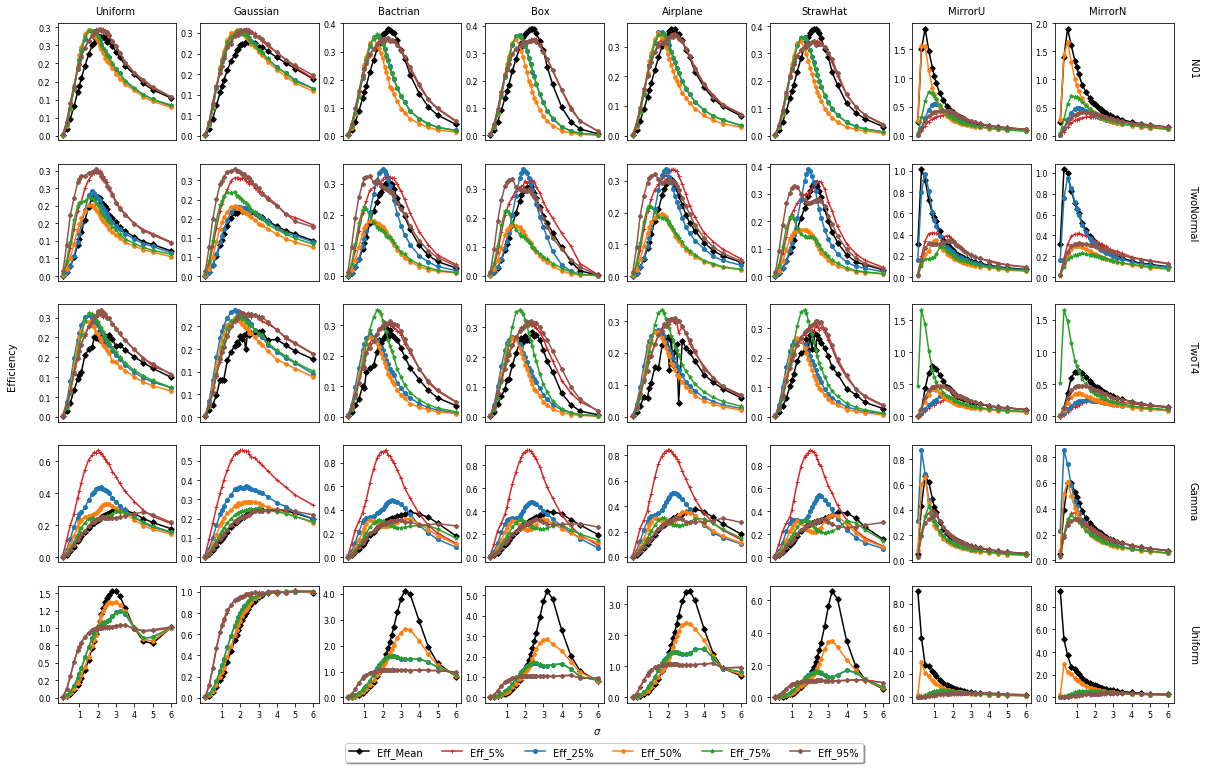

In [229]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,12.5)
fig, axlist = plt.subplots(5, 8,sharex=True)
for ax in axlist.flatten():
    pltindex = np.argmax(axlist.flatten() == ax)
    targetid = pltindex//8; kernelid = pltindex%8
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if targetid == 4:
        ax.tick_params(top=False, bottom=True, left=True, right=False, labelleft=True, labelbottom=True,labelsize = 8)
    else:
        ax.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=False,labelsize = 8)
    line1, = ax.plot(sigmaset, target_result[targetset[targetid]][0][kernelset[kernelid]], marker='D',color='Black',markersize=4,label = 'Eff_Mean')
    line2,line3,line4,line5,line6 = [ax.plot(sigmaset, [target_result[targetset[targetid]][5][kernelset[kernelid]][i][j] for i in range(27)], marker=marker[j],color=color[j],markersize=4,label = label[j]) for j in range(5)]
plt.xticks([1,2,3,4,5,6])
axlist.flatten()[-5].legend(loc='upper center', bbox_to_anchor=(1, -0.3), ncol=6, fancybox=True, shadow=True)
fig.tight_layout()
fig.text(0.5,0.09,'$\sigma$', ha='center')
fig.text(0.09,0.5, 'Efficiency', va='center', rotation='vertical')
[fig.text(0.91,0.83-0.16*i,targetset[i], va='center', rotation=-90) for i in range(5)]
[fig.text(0.165+0.0985*i,0.89,kernelset[i],ha='center') for i in range(8)]
plt.show()